In [33]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import PIL

In [34]:

images = []
labels = ["cat", "dog"]
y = []
data_path = os.getcwd() + "\\data"

# open images 

for label in labels: 
    image_path = os.path.join(data_path, label) 
    # get images 
    for file in os.listdir(image_path)[:2000]: 
        try: 
            file_path = os.path.join(image_path, file)
            img = PIL.Image.open(file_path)
            # convert to numpy array 
            resized_img = img.resize((150, 150))
            image_matrix = np.asarray(resized_img)
            if image_matrix.shape == (150, 150, 3):                 
                images.append(image_matrix)
                y.append(label)
        except OSError as e:
            print(f"Something wrong with this image : {file_path}")
        except Exception as e: 
            print(e)

Something wrong with this image : C:\Users\valentin\Desktop\learn_neural_nets\convolutions\first_convolution_layer\data\dog\11702.jpg


(150, 150, 3)


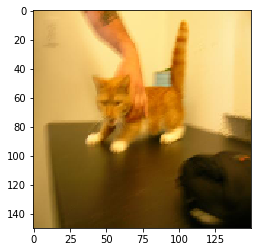

In [35]:
image =  images[0] 
print(image.shape) 
plt.imshow(image)

In [36]:
tensor = np.expand_dims(image, axis=0)

In [37]:
print(f"Tensor has shapes : {tensor.shape}")

Tensor has shapes : (1, 150, 150, 3)


In [38]:
def zero_padding(prev_A, pad): 
    '''
        Apply zero padding on the previous activation layer
        Argument : 
            prev_A : (m, n_h_prev, n_w_prev, n_c_prev)
            padding : int
    '''
    print(prev_A.shape)
    A = np.pad(prev_A, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    return A

(1, 150, 150, 3)


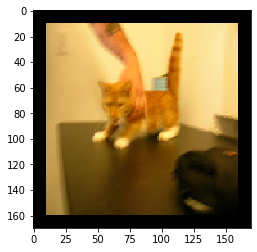

In [39]:
padded_tensor = zero_padding(tensor, 10)
plt.imshow(padded_tensor[0,...])

In [40]:
def single_convolution_step(prev_A, W, b, stride=1, padding=1): 
    '''
        implementing a single convolution step 
        
        Argument : 
            prev_A : (m, n_h_prev,n_w_prev, n_c_prev) 
            W : kernel (f, f, n_c)
            b : biaises (1, 1, 1, n_c)
            stride 
            padding
    '''
    
    Z = np.sum(np.multiply(prev_A, W)) + b 
    return Z

In [41]:
def convolution_pass(prev_A, W, b, stride=1, padding=1): 

    m, n_h_prev, n_w_prev, n_c_prev= prev_A.shape
    f, f, n_c_prev, n_c = W.shape
    
    n_h = int(((n_h_prev - f + 2* padding) / stride) + 1)
    n_w = int(((n_w_prev - f + 2*padding) / stride) + 1) 
    
    # output 
    Z = np.zeros((m, n_h, n_w, n_c))
    
    print(f"Output will have shape of : {Z.shape}")
    
    # convolution processs 
    prev_A_pad = zero_padding(prev_A, padding)
    for sample in range(m): 
        # get prev activation for the specific sample 
        prev_A_sample = prev_A_pad[sample, ...] 
        for h in range(n_h): 
            for w in range(n_w): 
                for c in range(n_c): 
                    
                    horiz_start = w * stride 
                    horiz_end = horiz_start + f
                    
                    vert_start = h * stride 
                    vert_end = vert_start + f
                    
                    # single convolution step on a specific part of the previous activation 
                    A_slice = prev_A_sample[horiz_start:horiz_end , vert_start:vert_end]
                    Z[sample, h, w, c] = single_convolution_step(A_slice, W[..., c], b[...,c], stride, padding) 
    
    # return Z and a cache 
    cache = (prev_A, W, b, stride, padding)
    
    return Z, cache
                    
                    

In [42]:
W = np.random.randn(7, 7,3,32)
b = np.random.randn(1,1,1,32)

convolved = convolution_pass(tensor, W, b, stride=1, padding=0)

Output will have shape of : (1, 144, 144, 32)
(1, 150, 150, 3)


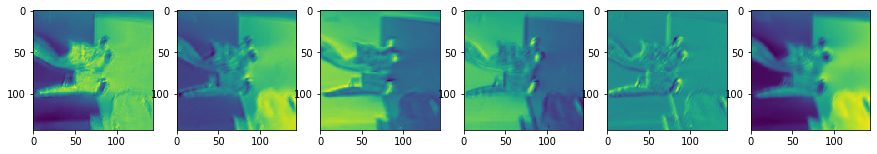

In [43]:
f, ax = plt.subplots(1,6, figsize=(15, 15))
j = 0
for i in range(6):
    ax[i].imshow(convolved[0][0, : , :, i])


In [44]:
def pooling_layer(prev_A, stride, f, method="max"): 
    '''
        apply a pooling layer 
        Argument : 
            prev_A : the previous layer activation of size (m, n_h_prev, n_w_prev, n_c_prev)
            stride : the stride 
            f : the size of the pooling layer (window size)
            method : the pooling method (max or average)
    '''
    
    # getting dimensiosn 
    m, n_h_prev, n_w_prev, n_c = prev_A.shape
    
    n_h = int(((n_h_prev - f) / stride) + 1)
    n_w = int(((n_w_prev - f) / stride) + 1)
    A = np.zeros((m, n_h, n_w, n_c))
    print(f"Output shapes : {A.shape}")
    
    # slicing 
    for sample in range(m): 
        # for each sample  
        sample_prev_A = prev_A[sample, ...] 
        for h in range(n_h): 
            for w in range(n_w): 
                # for each depth
                for c in range(n_c):
                    # get the slice 
                    vert_start = h * stride
                    vert_end = vert_start + f

                    horiz_start = w * stride 
                    horiz_end = horiz_start + f

                    slice_A = sample_prev_A[vert_start:vert_end , horiz_start:horiz_end, c] 
                    
                    if method == "max": 
                        A[sample, h, w, c] = np.max(slice_A)
                    elif method == "average": 
                        A[sample, h, w, c] = np.average(slice_A)
                        
    # caching for backprop 
    
    cache = (prev_A, stride, f, method) 
    return A, cache
     

Output shapes : (1, 75, 75, 3)


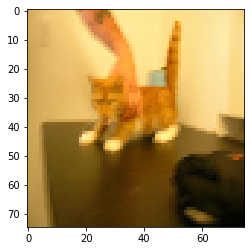

In [45]:
tensor = pooling_layer(tensor, 2, 2)[0] # classic max pooling layer 
plt.imshow(tensor[0, ...]/255.0)

(1, 150, 150, 3)